In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic_func, create_grid, prune_path
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local
import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()
    

In [3]:

def get_global_home(filename):
    with open(filename) as f:
        lat, lon = [float(x.replace("lat0 ", "").replace("lon0 ", "")) for x in f.readline().split(',')]
        gh = np.array([lon, lat, 0.0])
    return gh

In [4]:
def plot_map(grid, start, finish, path):
    
    if grid is not None:
        plt.imshow(grid, cmap='Greys', origin='lower')

    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    if start is not None:
        plt.plot(start[1], start[0], 'x')
        
    if finish is not None:
        plt.plot(finish[1], finish[0], 'x')

    if path is not None:
        pp = np.array(path)
        plt.plot(pp[:, 1], pp[:, 0], 'g')
        
    if grid is not None:
        plt.xlabel('EAST')
        plt.ylabel('NORTH')
        plt.show()

In [5]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5
        GLOBAL_GOAL = (-122.397336, 37.793836) 
        
        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        filename = 'colliders.csv'
        global_home = get_global_home(filename)
        
        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(global_home[0], global_home[1], global_home[2])

        # TODO: retrieve current global position 
        # TODO: convert to current local position using global_to_local()
        current_local_pos = global_to_local(self.global_position, global_home)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        
        print('local position from drone: {0}, local position (global_to_local): {1}'.format(self.local_position,
                                                                                           np.array(current_local_pos)))
        
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Determine offsets between grid and map
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        
        
        # TODO: convert start position to current position rather than map center
        grid_start = (int(current_local_pos[0]-north_offset), int(current_local_pos[1]- east_offset))
        
        # Set goal as some arbitrary position on the grid
        # TODO: adapt to set goal as latitude / longitude position and convert
        goal_pos = global_to_local([GLOBAL_GOAL[0], GLOBAL_GOAL[1], self._altitude], self.global_home)
        grid_goal = (int(goal_pos[0]-north_offset), int(goal_pos[1]-east_offset))
        
        print('Local Start and Goal: ', grid_start, grid_goal)

        plot_map(grid, grid_start, grid_goal, None)
        
        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        path, _ = a_star(grid, heuristic_func, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        obtimized_path = prune_path(path)
        
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        plot_map(grid, grid_start, grid_goal, obtimized_path)
        
        # Convert path to waypoints
        print('Setting Waypoints')
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in obtimized_path]
        # Set self.waypoints
        self.waypoints = waypoints
        # send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

Logs\TLog.txt
Logs\NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-122.3974484   37.7924811    0.212    ], local position [ 0.12329229  0.13578898 -0.2125046 ]
local position from drone: [ 0.12329229  0.13578898 -0.2125046 ], local position (global_to_local): [ 0.12295256  0.14008606 -0.212     ]
North offset = -316, east offset = -445
Local Start and Goal:  (316, 445) (466, 454)


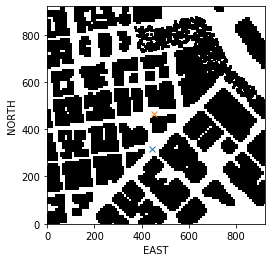

Found a path.


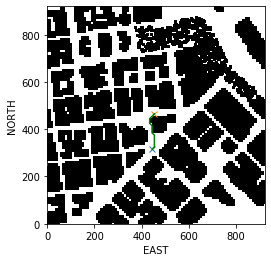

Setting Waypoints
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [9, 9, 5, 0]
waypoint transition
target position [59, 9, 5, 0]
waypoint transition
target position [69, -1, 5, 0]
waypoint transition
target position [99, -1, 5, 0]
waypoint transition
target position [109, -11, 5, 0]
waypoint transition
target position [129, -11, 5, 0]
waypoint transition
target position [149, 9, 5, 0]
waypoint transition
target position [150, 9, 5, 0]
landing transition
disarm transition
manual transition
Closing connection ...


In [6]:
#if __name__ == "__main__":
#    parser = argparse.ArgumentParser()
#    parser.add_argument('--port', type=int, default=5760, help='Port number')
#    parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
#    args = parser.parse_args()

#    conn = MavlinkConnection('tcp:{0}:{1}'.format(args.host, args.port), timeout=60)

# for python command line file remove comments above and delete the below conn line
# and include remaining code in the main function

conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)
drone = MotionPlanning(conn)
time.sleep(1)

drone.start()